In [1]:
import torch, os, copy, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import clear_output
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

from src.mechanism_base import *
from src.model_base import EmbedMLP
from src.utils import cross_entropy_high_precision, acc_rate

# Check if GPU is available
os.environ["CUDA_VISIBLE_DEVICES"] = os.environ.get("VSCODE_PROXY_CUDA_DEVICE", "")
# os.environ["CUDA_VISIBLE_DEVICES"] = os.environ["VSCODE_PROXY_CUDA_DEVICE"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Loading on device: {device}")


Loading on device: cpu


In [2]:
# Define the base path where the model and data files are stored

#base_path = '../saved_models/p_23_dmodel_23_dmlp_64_act_Quad_decay_0_fractrain_1_DFT_04201459' # Sparse initialization, Quad#base_path = '../saved_models/p_23_dmodel_23_dmlp_512_act_ReLU_decay_0_fractrain_1_DFT_05101058' # Full random, ReLU, Small Init#base_path = '../saved_models/p_23_dmodel_23_dmlp_128_act_ReLU_decay_0_fractrain_1_DFT_05071634' # Sparse initialization, ReLUbase_path = '../saved_models/p_23_dmodel_23_dmlp_128_act_Quad_decay_0_fractrain_1_DFT_04221446' # Full random, Quad, Small Init
#base_path = 'saved_models/p_23_dmodel_23_dmlp_128_act_ReLU_decay_0_fractrain_1_DFT_04221519' # justify early stage 

# Set model configuration parameters
d_vocab, d_model, d_mlp, act_type = 23, 23, 64, 'ReLU'  # Vocabulary size, model dimension, MLP size, and activation type
p = d_vocab  # Assign vocabulary size to variable `p`

# Define the file names for the model and data files
model_file = 'final.pth'        # File containing the trained model
train_data_file = 'train_data.pth'  # File containing the training data
test_data_file = 'test_data.pth'   # File containing the test data

# Load the model and data on the specified device
# Note: The `weights_only=True` argument assumes a custom loader function or a modified PyTorch function. 
# It is not standard in PyTorch's `torch.load`. This should be clarified or corrected.
model_data = torch.load(
    os.path.join(base_path, model_file),   # Path to the model file
    weights_only=True,                    # Load weights only (non-standard argument; ensure compatibility)
    map_location=device                   # Specify the device to load the model onto
)
print(f"Trained Model Dict: {model_data.keys()}\n")  # Print the keys of the loaded model dictionary

# Load the training and testing data
train_data = torch.load(
    os.path.join(base_path, train_data_file),  # Path to the training data file
    weights_only=True,                         # Load weights only (non-standard argument; ensure compatibility)
    map_location=device                        # Specify the device to load the data onto
)
test_data = torch.load(
    os.path.join(base_path, test_data_file),   # Path to the testing data file
    weights_only=True,                         # Load weights only (non-standard argument; ensure compatibility)
    map_location=device                        # Specify the device to load the data onto
)

# Extract the model parameters from the loaded model dictionary
model_load = model_data["model"]  # Access the model section of the dictionary
for key in model_load.keys():
    # Print each model parameter's key and its shape in a formatted manner
    print(f"{key:<30} {str(model_load[key].shape):<25}")

Trained Model Dict: dict_keys(['model', 'train_loss', 'test_loss', 'train_losses', 'test_losses', 'grad_norms', 'param_norms', 'epoch', 'optimizer', 'scheduler'])

embed.W_E                      torch.Size([23, 23])     
mlp.W_in                       torch.Size([128, 23])    
mlp.W_out                      torch.Size([23, 128])    
mlp.basis                      torch.Size([23, 23])     


In [3]:
model_data["train_loss"]

0.004447873216122389

In [4]:
all_data = torch.tensor([(i, j) for i in range(p) for j in range(p)]).to(device)
all_labels = torch.tensor([(i + j) % p for i, j in all_data]).to(device)
train_labels = torch.tensor([(i + j) % p for i, j in train_data]).to(device)

fourier_basis, fourier_basis_names = get_fourier_basis(p, device)
fourier_basis_unstd, _ = get_fourier_basis_unstd(p, device)

## Part 1: An Overview of Learned Model

### Part 1.1: Examine the Patterned Submodule

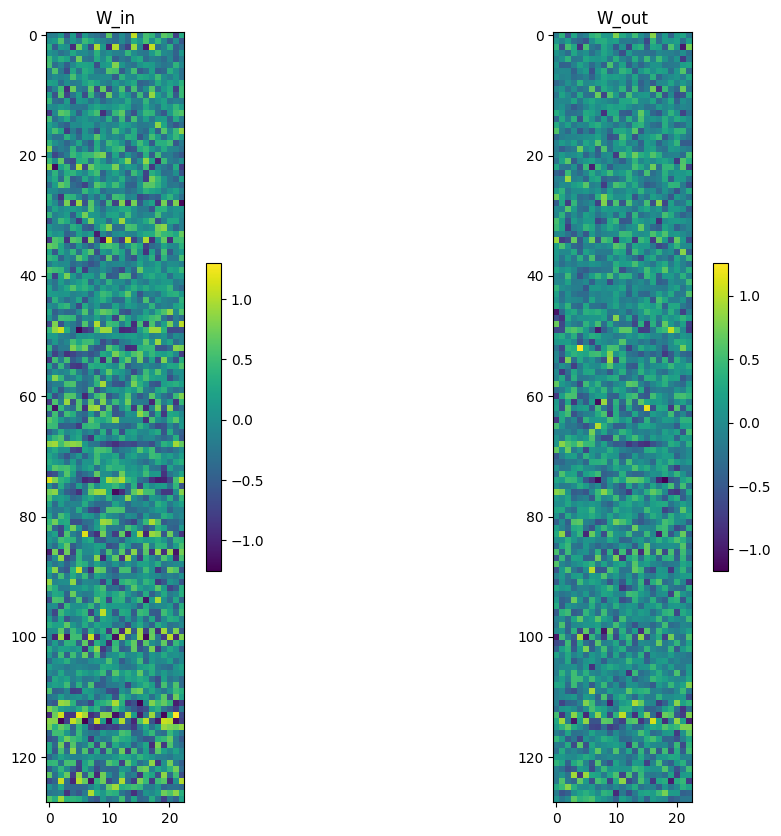

In [5]:
# Plot all four figures in one row
plt.figure(figsize=(12, 10))

# Heatmap (Binary Matrix from train_data)
plt.subplot(1, 2, 1)
#plt.imshow(model_load['mlp.W_in'] @ model_load['embed.W_E'], cmap='viridis')
plt.imshow(model_load['mlp.W_in'], cmap='viridis')
plt.title(f'W_in')
plt.colorbar(shrink=0.4)

# Heatmap (Binary Matrix from train_data)
plt.subplot(1, 2, 2) 
plt.imshow(model_load['mlp.W_out'].T, cmap='viridis')
plt.title(f'W_out')
plt.colorbar(shrink=0.4)

plt.show()

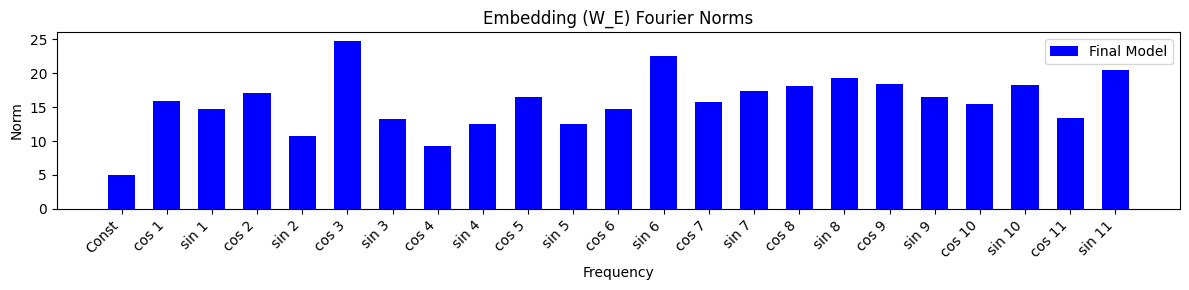

In [6]:
# Compute the norms of the Fourier components
#norms = (model_load['mlp.W_in'] @ model_load['embed.W_E'] @ fourier_basis.T).pow(2).sum(0).detach().cpu().numpy()
norms = (model_load['mlp.W_out'].T @ fourier_basis.T).pow(2).sum(0).detach().cpu().numpy()
#norms = (model_load['mlp.W_in']@ fourier_basis.T).pow(2).sum(0).detach().cpu().numpy()

# Plot the bar plot for "embed.W_E"
fig, ax = plt.subplots(figsize=(12, 3))

# x-axis labels
labels = fourier_basis_names
x = np.arange(len(labels))  # Frequency indices
width = 0.6  # Width of the bars

# Plot bars for the final model
ax.bar(x, norms, width, label="Final Model", color="blue")

# Customize plot
ax.set_title("Embedding (W_E) Fourier Norms")
ax.set_ylabel("Norm")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.legend()

# Add x-axis label and adjust layout
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

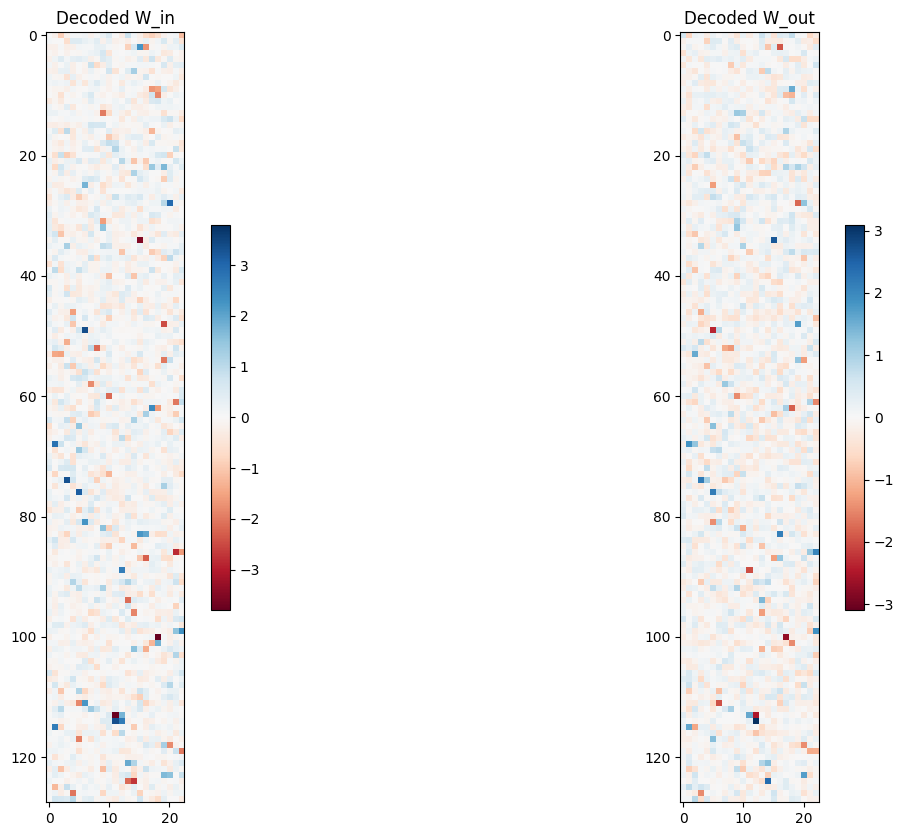

In [7]:
# Plot all four figures in one row
plt.figure(figsize=(15, 10))

# Heatmap (Binary Matrix from train_data)
plt.subplot(1, 2, 1)
#data = model_load['mlp.W_in'] @ model_load['embed.W_E'] @ fourier_basis.T
data = model_load['mlp.W_in'] @ fourier_basis.T
abs_max = np.abs(data).max()
plt.imshow(data, cmap='RdBu', vmin=-abs_max, vmax=abs_max)
plt.title(f'Decoded W_in')
plt.colorbar(shrink=0.5)

# Heatmap (Binary Matrix from train_data)
plt.subplot(1, 2, 2)
data = model_load['mlp.W_out'].T @ fourier_basis.T
abs_max = np.abs(data).max()
plt.imshow(data, cmap='RdBu', vmin=-abs_max, vmax=abs_max)
plt.title(f'Decoded W_out')
plt.colorbar(shrink=0.5)

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")

plt.show()

In [8]:
def decode_weights(model_load, fourier_basis_unstd):
    """
    Decodes the weights using the given model and Fourier basis, and computes the maximum frequency list.

    Parameters:
        model_load (dict): A dictionary containing the model's weights.
        fourier_basis_unstd (torch.Tensor): The Fourier basis matrix.

    Returns:
        tuple: A tuple containing:
            - W_in_decode (torch.Tensor): Decoded weights for W_in.
            - W_out_decode (torch.Tensor): Decoded weights for W_out.
            - max_freq_ls (list): List of maximum frequencies derived from W_in_decode.
    """
    # Decode the weights
    #W_in_decode = model_load['mlp.W_in'] @ model_load['embed.W_E'] @ fourier_basis_unstd.T
    W_in_decode = model_load['mlp.W_in'] @ fourier_basis_unstd.T
    W_out_decode = model_load['mlp.W_out'].T @ fourier_basis_unstd.T

    # Find the maximum frequency list
    max_ls = torch.argmax(abs(W_in_decode), dim=1)
    max_freq_ls = [(id.item() + 1) // 2 for id in max_ls]

    return W_in_decode, W_out_decode, max_freq_ls

In [9]:
model_data_early = torch.load(
    os.path.join(base_path, '20000.pth'),   # Path to the model file
    weights_only=True,                    # Load weights only (non-standard argument; ensure compatibility)
    map_location=device                   # Specify the device to load the model onto
)
model_load_early = model_data_early["model"]

W_in_decode, W_out_decode, max_freq_ls = decode_weights(model_load_early, fourier_basis)
coeff_in_scale_ls_all = []
coeff_out_scale_ls_all = []
coeff_phi_ls_all = []
coeff_psi_ls_all = []
coeff_diff_ls_all = []

for neuron in range(d_mlp):
    coeff_in_scale, coeff_in_phi = compute_neuron(neuron, max_freq_ls, W_in_decode)
    coeff_out_scale, coeff_out_phi = compute_neuron(neuron, max_freq_ls, W_out_decode)
    coeff_in_scale_ls_all.append(coeff_in_scale)
    coeff_phi_ls_all.append(coeff_in_phi)
    coeff_psi_ls_all.append(coeff_out_phi)
    coeff_diff_ls_all.append(2*coeff_in_phi-coeff_out_phi)

print(np.cos(np.array(coeff_diff_ls_all)).mean())
print(np.sin(np.array(coeff_diff_ls_all)).mean())

0.9893445721279012
-0.0010491955701013396


In [10]:
W_in_decode, W_out_decode, max_freq_ls = decode_weights(model_load, fourier_basis)
coeff_in_scale_ls_all = []
coeff_out_scale_ls_all = []
coeff_phi_ls_all = []
coeff_psi_ls_all = []
coeff_diff_ls_all = []

for neuron in range(d_mlp):
    coeff_in_scale, coeff_in_phi = compute_neuron(neuron, max_freq_ls, W_in_decode)
    coeff_out_scale, coeff_out_phi = compute_neuron(neuron, max_freq_ls, W_out_decode)
    coeff_in_scale_ls_all.append(coeff_in_scale)
    coeff_phi_ls_all.append(coeff_in_phi)
    coeff_psi_ls_all.append(coeff_out_phi)
    coeff_diff_ls_all.append(2*coeff_in_phi-coeff_out_phi)
    print(f"Neuron {neuron}: Freq {max_freq_ls[neuron]} , Scale {coeff_in_scale:.2f},{coeff_out_scale:.2f}, 2*Phi(in) {normalize_to_pi(2*coeff_in_phi):.2f}, Phi(out) {coeff_out_phi:.2f}")

Neuron 0: Freq 11 , Scale 1.14,0.67, 2*Phi(in) 2.95, Phi(out) 2.72
Neuron 1: Freq 2 , Scale 0.81,0.69, 2*Phi(in) 1.29, Phi(out) 1.52
Neuron 2: Freq 8 , Scale 2.78,1.94, 2*Phi(in) 1.28, Phi(out) 1.38
Neuron 3: Freq 5 , Scale 0.78,0.50, 2*Phi(in) 1.28, Phi(out) 1.23
Neuron 4: Freq 9 , Scale 0.87,0.73, 2*Phi(in) 0.94, Phi(out) 0.84
Neuron 5: Freq 4 , Scale 1.09,0.78, 2*Phi(in) 1.40, Phi(out) 1.54
Neuron 6: Freq 7 , Scale 1.36,1.10, 2*Phi(in) -2.43, Phi(out) -2.35
Neuron 7: Freq 8 , Scale 0.73,0.56, 2*Phi(in) 2.66, Phi(out) 2.45
Neuron 8: Freq 4 , Scale 0.51,0.22, 2*Phi(in) -2.48, Phi(out) -2.35
Neuron 9: Freq 9 , Scale 2.25,1.60, 2*Phi(in) -1.48, Phi(out) -1.30
Neuron 10: Freq 9 , Scale 1.95,1.43, 2*Phi(in) 2.39, Phi(out) 2.31
Neuron 11: Freq 9 , Scale 0.83,0.55, 2*Phi(in) -1.73, Phi(out) -1.50
Neuron 12: Freq 5 , Scale 0.58,0.21, 2*Phi(in) -1.02, Phi(out) -0.90
Neuron 13: Freq 5 , Scale 2.09,1.52, 2*Phi(in) -0.70, Phi(out) -0.71
Neuron 14: Freq 10 , Scale 1.01,0.74, 2*Phi(in) -1.90, Phi(

In [11]:
coeff_scale_ls = []
coeff_phi_ls = []
freq = 2

for neuron in [i for i, value in enumerate(max_freq_ls) if value == freq]:
    coeff_in_scale, coeff_in_phi = compute_neuron(neuron, max_freq_ls, W_in_decode)
    coeff_out_scale, coeff_out_phi = compute_neuron(neuron, max_freq_ls, W_out_decode)
    coeff_scale_ls.append(coeff_in_scale*coeff_out_scale)
    coeff_phi_ls.append(coeff_in_phi)
    print(f"Neuron {neuron}: Freq {max_freq_ls[neuron]}, Scale(in,out) {coeff_in_scale: .2f},{coeff_out_scale: .2f}, Phi(out) {normalize_to_pi(coeff_out_phi): .2f}, Phi(in)*2 {normalize_to_pi(2*coeff_in_phi): .2f}")

coeff_scale_ls = np.array(coeff_scale_ls)
coeff_phi_ls = np.array(coeff_phi_ls)

#for i in [1,2,4,6]: print(f"*{i} Mean of Sin: {np.mean(np.sin(i*coeff_phi_ls))} Mean of Cos: {np.mean(np.cos(i*coeff_phi_ls))}")
#for i in [1,2,4]: print(f"*{i} Sin: {np.mean(coeff_scale_ls*np.sin(i*coeff_phi_ls))/np.mean(coeff_scale_ls)} Cos: {np.mean(coeff_scale_ls*np.cos(i*coeff_phi_ls))/np.mean(coeff_scale_ls)}")
#plot_angles_on_circle(coeff_phi_ls)
#print(sum(coeff_scale_ls**3))

Neuron 1: Freq 2, Scale(in,out)  0.81, 0.69, Phi(out)  1.52, Phi(in)*2  1.29
Neuron 20: Freq 2, Scale(in,out)  1.07, 0.82, Phi(out) -1.12, Phi(in)*2 -1.07
Neuron 35: Freq 2, Scale(in,out)  1.25, 0.93, Phi(out)  0.36, Phi(in)*2  0.34
Neuron 42: Freq 2, Scale(in,out)  0.68, 0.47, Phi(out)  0.79, Phi(in)*2  0.87
Neuron 43: Freq 2, Scale(in,out)  0.84, 0.52, Phi(out)  1.25, Phi(in)*2  1.02
Neuron 46: Freq 2, Scale(in,out)  1.57, 1.18, Phi(out) -2.84, Phi(in)*2 -2.85
Neuron 51: Freq 2, Scale(in,out)  1.42, 0.94, Phi(out)  0.54, Phi(in)*2  0.45
Neuron 55: Freq 2, Scale(in,out)  1.28, 0.90, Phi(out)  1.83, Phi(in)*2  1.77
Neuron 70: Freq 2, Scale(in,out)  0.56, 0.51, Phi(out)  3.12, Phi(in)*2 -3.04
Neuron 71: Freq 2, Scale(in,out)  0.72, 0.67, Phi(out)  1.93, Phi(in)*2  1.67
Neuron 72: Freq 2, Scale(in,out)  0.94, 0.75, Phi(out) -1.60, Phi(in)*2 -1.55
Neuron 74: Freq 2, Scale(in,out)  3.39, 2.40, Phi(out) -0.45, Phi(in)*2 -0.43
Neuron 88: Freq 2, Scale(in,out)  0.46, 0.35, Phi(out) -0.47, Phi

# Process Checking

In [12]:
all_files = [os.path.join(base_path, f) for f in os.listdir(base_path) if os.path.isfile(os.path.join(base_path, f))]

loaded_files = {} # Initialize the dictionary to store the loaded files
exclude_files = {'final.pth', 'test_data.pth', 'train_data.pth'} # Define the files to exclude

# Loop through all files in the directory
for file_name in os.listdir(base_path):
    file_path = os.path.join(base_path, file_name)
    # Check if it's a file, has the correct extension, and is not in the exclude list
    if os.path.isfile(file_path) and file_name.endswith('.pth') and file_name not in exclude_files:
        # Extract the final ID from the filename (remove extension and convert to int)
        final_id = int(os.path.splitext(file_name)[0])
        # Load the file (assuming it's a PyTorch model)
        loaded_files[final_id] = torch.load(file_path, weights_only=True, map_location=device)["model"]
loaded_files = {key: loaded_files[key] for key in sorted(loaded_files)}

In [13]:
def plot_model(key):
    # Retrieve the model state dict using the selected key
    model_load = loaded_files[key]
    
    # Create the figure with two subplots
    plt.figure(figsize=(15, 10))
    
    # First subplot: Decoded W_in
    plt.subplot(1, 2, 1)
    # Compute data (example: W_in multiplied by the transpose of the fourier_basis)
    data_in = model_load['mlp.W_in'] @ fourier_basis.T
    abs_max_in = np.abs(data_in).max()
    plt.imshow(data_in, cmap='RdBu', vmin=-abs_max_in, vmax=abs_max_in)
    plt.title('Decoded W_in')
    plt.colorbar(shrink=0.5)
    
    # Second subplot: Decoded W_out
    plt.subplot(1, 2, 2)
    # Compute data (example: transpose of W_out multiplied by the transpose of the fourier_basis)
    data_out = model_load['mlp.W_out'].T @ fourier_basis.T
    abs_max_out = np.abs(data_out).max()
    plt.imshow(data_out, cmap='RdBu', vmin=-abs_max_out, vmax=abs_max_out)
    plt.title('Decoded W_out')
    plt.colorbar(shrink=0.5)

    plt.suptitle(f'Model Key: {key}')
    plt.show()

# Create a selection slider with the sorted keys from your loaded_files dictionary
key_options = sorted(loaded_files.keys())
interact(plot_model, key=widgets.SelectionSlider(options=key_options, description='Model Key'));


interactive(children=(SelectionSlider(description='Model Key', options=(0, 1000, 2000, 3000, 4000, 5000, 6000,…

In [14]:
def interactive_model(key):
    # Clear previous outputs so the new model's output is shown clearly
    clear_output(wait=True)
    
    # Retrieve the model using the selected key
    model_load = loaded_files[key]
    
    # Decode the weights from the selected model
    W_in_decode, W_out_decode, max_freq_ls = decode_weights(model_load, fourier_basis)
    
    # Determine the number of neurons (assuming the first dimension of W_in_decode equals d_mlp)
    d_mlp = W_in_decode.shape[0]
    print(f"Loaded Model Key: {key} with {d_mlp} neurons.\n")
    
    # Loop through each neuron and print the computed details
    for neuron in range(d_mlp):
        coeff_in_scale, coeff_in_phi = compute_neuron(neuron, max_freq_ls, W_in_decode)
        coeff_out_scale, coeff_out_phi = compute_neuron(neuron, max_freq_ls, W_out_decode)
        print(f"Neuron {neuron}: Freq {max_freq_ls[neuron]}, "
              f"Scale {coeff_in_scale:.4f},{coeff_out_scale:.4f}, "
              f"2*Phi(in) {normalize_to_pi(2*coeff_in_phi):.2f}, "
              f"Phi(out) {coeff_out_phi:.2f}",
              f"Scale Diff {coeff_in_scale**2-2*coeff_out_scale**2:.8f}")

# Create an interactive widget for model selection using the keys in loaded_files.
model_keys = sorted(loaded_files.keys())
interact(interactive_model, key=widgets.SelectionSlider(options=model_keys, description='Model Key'));



interactive(children=(SelectionSlider(description='Model Key', options=(0, 1000, 2000, 3000, 4000, 5000, 6000,…

In [15]:
# Create a single list of all neuron‐records (dropping the model key)
all_neuron_records = []
sparse_level_ls =[]

for model in loaded_files.values():
    # Decode this model’s weights
    W_in_decode, W_out_decode, max_freq_ls = decode_weights(model, fourier_basis)
    d_mlp = W_in_decode.shape[0]
    sparse_level_ls.append((W_in_decode.norm(p=4, dim=1)**4/W_in_decode.norm(p=2, dim=1)**4).mean()/2 + (W_out_decode.norm(p=4, dim=1)**4/W_out_decode.norm(p=2, dim=1)**4).mean()/2)


    for neuron in range(d_mlp):
        coeff_in_scale, coeff_in_phi  = compute_neuron(neuron, max_freq_ls, W_in_decode)
        coeff_out_scale, coeff_out_phi = compute_neuron(neuron, max_freq_ls, W_out_decode)
        scale_diff = coeff_in_scale**2 - 2 * coeff_out_scale**2

        # Append just the neuron‐level info
        all_neuron_records.append({
            "neuron":     neuron,
            "frequency":  max_freq_ls[neuron],
            "scale_in":   coeff_in_scale,
            "phi_in":     coeff_in_phi,
            "scale_out":  coeff_out_scale,
            "phi_out":    coeff_out_phi,
            "scale_diff": scale_diff
        })

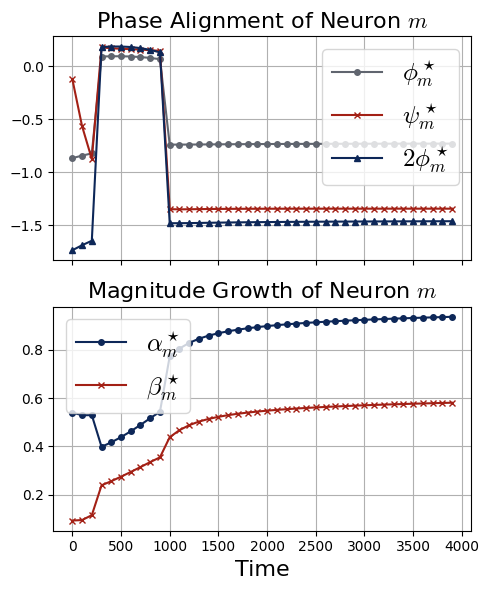

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Rebuild the lists for neuron 35 (assumes all_neuron_records exists)
neuron_records = [r for r in all_neuron_records if r["neuron"] == 15][:-10]

phi_in_list    = [r["phi_in"]    for r in neuron_records]
phi_out_list   = [r["phi_out"]   for r in neuron_records]
phi2_in_list   = [2 * v          for v in phi_in_list]
scale_in_list  = [r["scale_in"]  for r in neuron_records]
scale_out_list = [r["scale_out"] for r in neuron_records]

# X-axis scaled by 1000
x = np.arange(len(phi_in_list)) * 100

colors = ['#0D2758', '#60656F', '#DEA54B', '#A32015', '#347186']
plt.rcParams['mathtext.fontset'] = 'cm'

# Create subplots
#fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 6), sharex=True)

ax1.plot(x, phi_in_list,  marker='o', markersize=4, color=colors[1], label=r"$\phi_m^\star$")
ax1.plot(x, phi_out_list, marker='x', markersize=4, color=colors[3], label=r"$\psi_m^\star$")
ax1.plot(x, phi2_in_list, marker='^', markersize=4, color=colors[0], label=r"$2\phi_m^\star$")
ax1.set_title('Phase Alignment of Neuron $m$', fontsize=16)
ax1.legend(fontsize=18, loc="upper right")
ax1.grid(True)

ax2.plot(x, scale_in_list,  marker='o', markersize=4, color=colors[0], label=r"$\alpha_m^\star$")
ax2.plot(x, scale_out_list, marker='x', markersize=4, color=colors[3], label=r"$\beta_m^\star$")
ax2.set_title('Magnitude Growth of Neuron $m$', fontsize=16)
ax2.set_xlabel('Time', fontsize=16)
ax2.legend(fontsize=18, loc="upper left")
ax2.grid(True)

plt.tight_layout()
#plt.savefig('phase_align_relu.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()


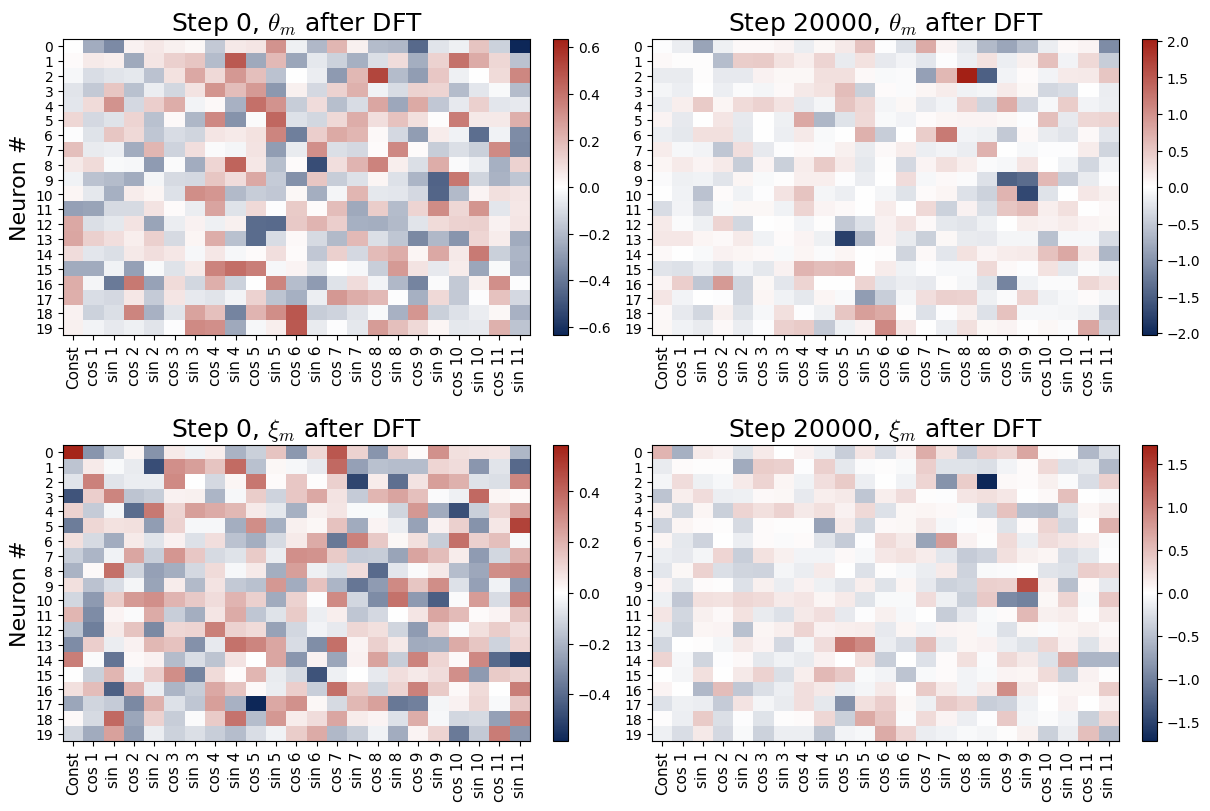

In [17]:
# Create a custom colormap that centers 'cividis' with white at zero
cividis_with_white = LinearSegmentedColormap.from_list(
    'cividis_white_center', 
    ['#0D2758', 'white', '#A32015'],  # Colors at low, middle, and high points in 'cividis'
    N=256
)

def plot_decoded_weights(
    loaded_files,
    fourier_basis,
    fourier_basis_names,
    keys,
    num_components=20
):
    """
    Plots decoded W_in and W_out for each key in `keys`.

    Parameters
    ----------
    loaded_files : list of dict
        Each element is a dict containing 'mlp.W_in' and 'mlp.W_out'.
    fourier_basis : np.ndarray
        Your Fourier basis matrix of shape (p, p).
    fourier_basis_names : list of str
        Names/labels for each Fourier mode (length p).
    keys : list of int
        Indices into loaded_files to plot.
    num_components : int, optional
        How many top components (rows) to show, by default 20.
    """
    n = len(keys)
    #fig, axes = plt.subplots(2, n, figsize=(18, 3.3 * n), gridspec_kw={"hspace": 0.05}, constrained_layout=True)
    fig, axes = plt.subplots(2, n, figsize=(12, 4 * n), gridspec_kw={"hspace": 0.05}, constrained_layout=True)

    # Ensure axes is always 2×n
    if n == 1:
        axes = axes.reshape(2, 1)

    x_locs = np.arange(len(fourier_basis_names))
    y_locs = np.arange(num_components)

    for col, key in enumerate(keys):
        W_in = loaded_files[key]['mlp.W_in']
        W_out = loaded_files[key]['mlp.W_out']

        # --- Decoded W_in on row 0, col `col`
        data_in = (W_in @ fourier_basis.T)[:num_components]
        abs_max_in = np.abs(data_in).max()
        ax_in = axes[0, col]
        im_in = ax_in.imshow(
            data_in,
            cmap=cividis_with_white,
            vmin=-abs_max_in,
            vmax= abs_max_in,
            aspect='auto'
        )
        ax_in.set_title(rf'Step {key}, $\theta_m$ after DFT', fontsize=18)
        ax_in.set_xticks(x_locs)
        ax_in.set_xticklabels(fourier_basis_names, rotation=90, fontsize=11)
        ax_in.set_yticks(y_locs)
        ax_in.set_yticklabels(y_locs)
        if key == 0: ax_in.set_ylabel('Neuron #', fontsize=16)
        fig.colorbar(im_in, ax=ax_in)

        # --- Decoded W_out on row 1, col `col`
        data_out = (W_out.T @ fourier_basis.T)[:num_components]
        abs_max_out = np.abs(data_out).max()
        ax_out = axes[1, col]
        im_out = ax_out.imshow(
            data_out,
            cmap=cividis_with_white,
            vmin=-abs_max_out,
            vmax= abs_max_out,
            aspect='auto'
        )
        ax_out.set_title(rf'Step {key}, $\xi_m$ after DFT', fontsize=18)
        ax_out.set_xticks(x_locs)
        ax_out.set_xticklabels(fourier_basis_names, rotation=90, fontsize=11)
        ax_out.set_yticks(y_locs)
        ax_out.set_yticklabels(y_locs)
        if key == 0: ax_out.set_ylabel('Neuron #', fontsize=16)
        fig.colorbar(im_out, ax=ax_out)
    
    #plt.tight_layout()
    #plt.savefig('single_freq_relu_full_random_init.jpg', format='jpg', dpi=300, bbox_inches='tight')
    plt.show()


# Example usage:
keys = [0, 20000]  # whatever subset of loaded_files you want
plot_decoded_weights(loaded_files, fourier_basis, fourier_basis_names, keys, num_components=20)


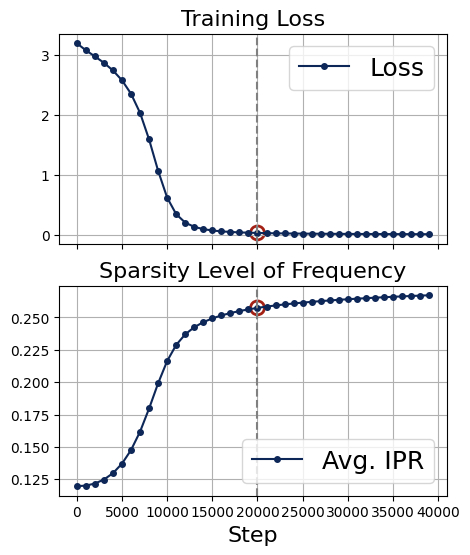

In [18]:
vline_x = 20000
vline_kwargs = dict(color='gray', linestyle='--', linewidth=1.5)

# X-axis scaled by 1000
x = np.arange(len(phi_in_list)) * 1000

# precompute your y-data slices
y_loss       = model_data["train_losses"][::1000][:-10]
y_sparsity   = sparse_level_ls[:-10]

# find the index of the point closest to x=20000
idx = np.argmin(np.abs(x - vline_x))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 6), sharex=True)

# --- Loss plot
ax1.plot(x, y_loss,  marker='o', markersize=4, color=colors[0], label="Loss")
ax1.axvline(x=vline_x, **vline_kwargs)

# highlight the point
ax1.scatter( vline_x,
             y_loss[idx],
             s=100,                   # size of the highlight
             facecolors='none',       # hollow
             edgecolors=colors[3],        # red outline
             linewidths=2,
           )
ax1.set_title('Training Loss', fontsize=16)
ax1.legend(fontsize=18, loc="upper right")
ax1.grid(True)


# --- Sparsity plot
ax2.plot(x, y_sparsity,  marker='o', markersize=4, color=colors[0], label="Avg. IPR")
ax2.axvline(x=vline_x, **vline_kwargs)
ax2.scatter( vline_x,
             y_sparsity[idx],
             s=100,
             facecolors='none',
             edgecolors=colors[3],
             linewidths=2,
           )
ax2.set_title('Sparsity Level of Frequency', fontsize=16)
ax2.set_xlabel('Step', fontsize=16)
ax2.legend(fontsize=18, loc="lower right")
ax2.grid(True)

#plt.savefig('loss_sparsity_relu.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()


In [19]:
# # 1. Define the custom colormap
# cividis_with_white = LinearSegmentedColormap.from_list(
#     'cividis_white_center',
#     ['#0D2758', 'white', '#A32015'],
#     N=256
# )

# # 2. Prepare data for plotting (as per your provided code)
# arr = np.array(coeff_in_scale_ls_all)
# # find the 20th largest value
# threshold = np.partition(arr, -21)[-21]
# # mask all entries ≥ that threshold
# mask = arr >= threshold #1.79#2.425 # Example threshold
# max_freq_ls = np.array(max_freq_ls)
# freq_ls = max_freq_ls[mask]
# W_in_data_filtered = model_load['mlp.W_in'][mask, :]
# W_out_T_data_filtered = model_load['mlp.W_out'].T[mask, :]

# # The following operations can error if freq_ls is empty,
# # leading to ranked_W_in_data / ranked_W_out_T_data being empty,
# # and then the .max() calls below will raise a ValueError.
# # This follows your request to adhere to the original code structure.
# sorted_indices = np.argsort(freq_ls)
# ranked_freq_ls = freq_ls[sorted_indices]
# ranked_W_in_data = W_in_data_filtered[sorted_indices, :]
# ranked_W_out_T_data = W_out_T_data_filtered[sorted_indices, :]

# # 3. Create the figure and subplots
# # Figure size adapted from the example's (12, 4*n) for (2,n) subplots.
# # For this (2,1) layout (n=1 equivalent column), (7,9) provides a balanced look.
# # gridspec_kw is also from the example to control spacing.
# fig, axes = plt.subplots(2, 1, figsize=(6, 8), constrained_layout=True, gridspec_kw={"hspace": 0.05})

# # --- Plot for W_in (Top Plot) ---
# ax_in = axes[0]
# abs_max_in = np.abs(ranked_W_in_data).max() * 1.15 # Your original scaling
# im_in = ax_in.imshow(
#     ranked_W_in_data,
#     cmap=cividis_with_white,
#     vmin=-abs_max_in,
#     vmax=abs_max_in,
#     aspect='auto'
# )
# ax_in.set_title(r'First-Layer Parameters $\theta_m$', fontsize=18) # Title fontsize from example
# fig.colorbar(im_in, ax=ax_in)

# # X/Y axis styling based on example
# num_rows_in = ranked_W_in_data.shape[0]
# num_cols_in = ranked_W_in_data.shape[1]
# y_locs_in = np.arange(num_rows_in)
# x_locs_in = np.arange(num_cols_in) # Assuming columns are simple indices

# ax_in.set_yticks(y_locs_in)
# ax_in.set_yticklabels(y_locs_in, fontsize=11) # Tick label fontsize from example
# ax_in.set_ylabel('Neuron #', fontsize=16)     # Y-axis label and fontsize from example

# ax_in.set_xticks(x_locs_in)
# # Using column indices as x-tick labels, styled as per example
# ax_in.set_xticklabels(x_locs_in, rotation=90, fontsize=11)
# # Your original ax_in.set_xlabel is replaced by these more specific tick labels

# # --- Plot for W_out.T (Bottom Plot) ---
# ax_out = axes[1]
# abs_max_out = np.abs(ranked_W_out_T_data).max() * 0.95 # Your original scaling
# im_out = ax_out.imshow(
#     ranked_W_out_T_data,
#     cmap=cividis_with_white,
#     vmin=-abs_max_out,
#     vmax=abs_max_out,
#     aspect='auto'
# )
# ax_out.set_title(r'Second-Layer Parameters $\xi_m$', fontsize=18) # Title fontsize from example
# fig.colorbar(im_out, ax=ax_out)

# # X/Y axis styling based on example
# num_rows_out = ranked_W_out_T_data.shape[0]
# num_cols_out = ranked_W_out_T_data.shape[1]
# y_locs_out = np.arange(num_rows_out)
# x_locs_out = np.arange(num_cols_out) # Assuming columns are simple indices

# ax_out.set_yticks(y_locs_out)
# ax_out.set_yticklabels(y_locs_out, fontsize=11) # Tick label fontsize from example
# ax_out.set_ylabel('Neuron #', fontsize=16)     # Y-axis label and fontsize from example

# ax_out.set_xticks(x_locs_out)
# # Using column indices as x-tick labels, styled as per example
# ax_out.set_xticklabels(x_locs_out, rotation=90, fontsize=11)
# ax_out.set_xlabel('Input / Output Dimension', fontsize=16)
# # Your original ax_out.set_xlabel is replaced
# #plt.savefig('full_training_para_origin.jpg', format='jpg', dpi=300, bbox_inches='tight')
# # 4. Display the plot
# plt.show()

In [20]:
# # assume ranked_W_in_data is a pandas DataFrame or a 2D NumPy array
# top5 = ranked_W_in_data.iloc[:5] if hasattr(ranked_W_in_data, 'iloc') else ranked_W_in_data[:5]

# fig, axes = plt.subplots(
#     nrows=5,
#     ncols=1,
#     figsize=(5, 8),
#     constrained_layout=True,
#     gridspec_kw={'hspace': 0.02}
# )

# for i, ax in enumerate(axes):
#     data = top5.iloc[i].values if hasattr(top5, 'iloc') else top5[i]
#     data_est = (p := data @ fourier_basis.T) * np.isin(np.arange(p.shape[0]), np.argpartition(-np.abs(p), 2)[:2]) @ fourier_basis
#     ax.plot(data, marker='o', markersize=5, color=colors[0], linewidth=1.5, linestyle=':', label="Actual")
#     ax.plot(data_est, marker='o', markersize=5, color=colors[3], linewidth=1.5, linestyle=':', alpha=0.7, label="Fitted")
#     ax.set_ylim(-1, 1)
#     ax.set_ylabel(f'Neuron #{i}', fontsize=16)
#     positions = np.arange(len(x_locs_out))
#      # set common x-ticks for vertical grid lines
#     ax.set_xticks(positions)
#     # draw grid on both x and y axes
#     ax.grid(True,
#             which='major',
#             axis='both',        # <--- grid on both axes
#             linestyle='--',
#             linewidth=0.5,
#             alpha=0.6)

#     # only bottom axis shows labels
#     if i < len(axes) - 1:
#         ax.set_xticklabels([])

# # configure bottom subplot's ticks and labels properly
# ax_bottom = axes[-1]
# ax_bottom.set_xlabel('Input Dimension', fontsize=16)

# # define tick positions (must match number of labels)
# positions = np.arange(len(x_locs_out))
# ax_bottom.set_xticks(positions)
# ax_bottom.set_xticklabels(x_locs_out, rotation=90, fontsize=11)
# axes[0].set_title(r'First-Layer Parameters $\theta_m$', fontsize=18)
# axes[0].legend(fontsize=14, loc="upper right")
# plt.savefig('full_training_para_origin_lineplot_in.jpg', format='jpg', dpi=300, bbox_inches='tight')
# plt.show()

In [21]:
# # assume ranked_W_in_data is a pandas DataFrame or a 2D NumPy array
# top5 = ranked_W_out_T_data.iloc[:5] if hasattr(ranked_W_out_T_data, 'iloc') else ranked_W_out_T_data[:5]

# fig, axes = plt.subplots(
#     nrows=5,
#     ncols=1,
#     figsize=(5, 8),
#     constrained_layout=True,
#     gridspec_kw={'hspace': 0.02}
# )

# for i, ax in enumerate(axes):
#     data = top5.iloc[i].values if hasattr(top5, 'iloc') else top5[i]
#     data_est = (p := data @ fourier_basis.T) * np.isin(np.arange(p.shape[0]), np.argpartition(-np.abs(p), 2)[:2]) @ fourier_basis
#     ax.plot(data, marker='o', markersize=5, color=colors[0], linewidth=1.5, linestyle=':', label="Actual")
#     ax.plot(data_est, marker='o', markersize=5, color=colors[3], linewidth=1.5, linestyle=':', alpha=0.7, label="Fitted")
#     ax.set_ylim(-1.4, 1.4)
#     ax.set_ylabel(f'Neuron #{i}', fontsize=16)
#      # set common x-ticks for vertical grid lines
#     ax.set_xticks(positions)
#     # draw grid on both x and y axes
#     ax.grid(True,
#             which='major',
#             axis='both',        # <--- grid on both axes
#             linestyle='--',
#             linewidth=0.5,
#             alpha=0.6)

#     # only bottom axis shows labels
#     if i < len(axes) - 1:
#         ax.set_xticklabels([])

# # configure bottom subplot's ticks and labels properly
# ax_bottom = axes[-1]
# ax_bottom.set_xlabel('Output Dimension', fontsize=16)

# # define tick positions (must match number of labels)
# positions = np.arange(len(x_locs_out))
# ax_bottom.set_xticks(positions)
# ax_bottom.set_xticklabels(x_locs_out, rotation=90, fontsize=11)
# axes[0].legend(fontsize=14, loc="upper right")
# axes[0].set_title(r'Second-Layer Parameters $\xi_m$', fontsize=18)
# plt.savefig('full_training_para_origin_lineplot_out.jpg', format='jpg', dpi=300, bbox_inches='tight')
# plt.show()

In [22]:
# coeff_scale_ls = []
# coeff_phi_ls = []
# freq = 5

# for neuron in [i for i, value in enumerate(max_freq_ls) if value == freq]:
#     coeff_in_scale, coeff_in_phi = compute_neuron(neuron, max_freq_ls, W_in_decode)
#     coeff_out_scale, coeff_out_phi = compute_neuron(neuron, max_freq_ls, W_out_decode)
#     coeff_scale_ls.append(coeff_in_scale*coeff_out_scale)
#     coeff_phi_ls.append(coeff_in_phi)
#     #print(f"Neuron {neuron}: Freq {max_freq_ls[neuron]}, Scale(in,out) {coeff_in_scale: .2f},{coeff_out_scale: .2f}, Phi(out) {normalize_to_pi(coeff_out_phi): .2f}, Phi(in)*2 {normalize_to_pi(2*coeff_in_phi): .2f}")

# coeff_scale_ls = np.array(coeff_scale_ls)
# coeff_phi_ls = np.array(coeff_phi_ls)

# # assume coeff_phi_ls is your 1D array of φₘ
# multipliers = [1, 2, 3, 4,5,6,7,8]
# results = {}

# for m in multipliers:
#     mean_cos = np.mean(np.cos(m * coeff_phi_ls))
#     mean_sin = np.mean(np.sin(m * coeff_phi_ls))
#     results[m] = (mean_cos, mean_sin)

# # print them out
# for m, (c, s) in results.items():
#     print(f"m={m:>1} → ⟨cos({m}φₘ)⟩ = {c:.4f}, ⟨sin({m}φₘ)⟩ = {s:.4f}")


In [23]:
# import numpy as np
# import matplotlib.pyplot as plt

# # assume coeff_phi_ls is your array of φₘ
# # assume colors is defined (e.g. a list of color strings)

# theta = np.linspace(0, 2*np.pi, 300)

# # define multipliers and a matching sequence of radii
# multipliers = [1, 2, 3, 4]
# radii       = [1.0, 0.88, 0.76, 0.64]

# fig, ax = plt.subplots(figsize=(4,4))

# for m, r in zip(multipliers, radii):
#     # draw the circle of radius r
#     x_c, y_c = r*np.cos(theta), r*np.sin(theta)
#     ax.plot(x_c, y_c, linewidth=0.8, color='gray', alpha=0.6)
    
#     # compute and plot points at angles m*φₘ, but on that circle of radius r
#     x_pts = r * np.cos(m * coeff_phi_ls)
#     y_pts = r * np.sin(m * coeff_phi_ls)
#     if m > 1:
#         ax.scatter(
#             x_pts, y_pts,
#             s=20,
#             marker='o',
#             color=colors[m-1],
#             label=fr'${m}\phi_m$'
#         )
#     else:
#         ax.scatter(
#             x_pts, y_pts,
#             s=20,
#             marker='o',
#             color=colors[m-1],
#             label=fr'$\phi_m$'
#         )


# # floating legend
# ax.legend(
#     fontsize=14,
#     loc='upper center',
#     columnspacing=0.2,
#     handletextpad=0.1,
#     bbox_to_anchor=(0.5, 1.15),
#     ncol=4,
#     frameon=False
# )

# ax.set_xlabel(r'$\cos(\phi_m)$', fontsize=16)
# ax.set_ylabel(r'$\sin(\phi_m)$', fontsize=16)

# ax.set_xticks([])
# ax.set_yticks([])
# for spine in ax.spines.values():
#     spine.set_visible(False)
# # strip away all axes and spines
# #ax.set_axis_off()
# plt.savefig('full_training_phase_distribution.jpg', format='jpg', dpi=300, bbox_inches='tight')
# plt.show()



In [24]:
# import numpy as np
# import matplotlib.pyplot as plt

# coeff_2phi_ls_all = np.array([normalize_to_pi(2*φ) for φ in coeff_phi_ls_all])
# coeff_psi_ls_all  = np.array(coeff_psi_ls_all)
# coeff_phi_ls_all  = np.array(coeff_phi_ls_all)

# cond = (coeff_2phi_ls_all / coeff_psi_ls_all < 0) & (coeff_2phi_ls_all < -3)

# fig, ax = plt.subplots(figsize=(4,4))

# # scatter points
# ax.scatter(
#     coeff_2phi_ls_all[~cond],
#     coeff_psi_ls_all[~cond],
#     marker='.',
#     color=colors[3],
#     s=20,
#     label=r'$(2\phi_m,\psi_m)$'
# )
# ax.scatter(
#     coeff_phi_ls_all[~cond],
#     coeff_psi_ls_all[~cond],
#     marker='.',
#     color=colors[0],
#     s=20,
#     label=r'$(\phi_m,\psi_m)$'
# )

# # add reference lines
# x_min, x_max = ax.get_xlim()
# x_line = np.linspace(x_min, x_max, 200)
# ax.plot(x_line,   x_line,       linestyle='--', color='gray', alpha=0.7)
# ax.plot(x_line,   2*x_line,     linestyle='--', color='gray', alpha=0.7)
# ax.plot(x_line,   2*x_line+2*np.pi, linestyle='--', color='gray', alpha=0.7)
# ax.plot(x_line,   2*x_line-2*np.pi, linestyle='--', color='gray', alpha=0.7)

# # labels & grid
# ax.set_xlabel(r'Normalized $\phi_m$', fontsize=16)
# ax.set_ylabel(r'$\psi_m$', fontsize=16)
# ax.set_ylim(-np.pi*1.1, np.pi*1.1)
# ax.grid(True)

# # legend above plot
# ax.legend(
#     fontsize=16,
#     ncol=2,
#     loc='upper center',
#     frameon=False,
#     bbox_to_anchor=(0.5, 1.25),
#     columnspacing=0.4,   # horizontal space between columns
#     handletextpad=0.1,   # space between marker and text
#     labelspacing=0.2,    # vertical space between rows (not used for single row)
#     borderaxespad=0.9   # padding between axes and legend box
# )

# plt.savefig('../figures/full_training_phase_relationship.jpg', format='jpg', dpi=300, bbox_inches='tight')
# plt.show()


In [25]:
x, y, j, p = 1, 12, 2, 17
output = 0
freq_ls = np.arange(1, (p+1)/2)
phi_ls = np.linspace(0, 2*np.pi, 16, endpoint=False)
for m in range(len(freq_ls)):
    for n in range(len(phi_ls)):
        output += np.cos(2*freq_ls[m]*np.pi/p*j+2*phi_ls[n]) * (np.cos(2*freq_ls[m]*np.pi/p*x+phi_ls[n]) + np.cos(2*freq_ls[m]*np.pi/p*y+phi_ls[n]))**2

print(f'{output}')

# output = 0
# freq_ls = np.arange(1, (p-1)/2)
# phi_ls = np.linspace(0, 2*np.pi, 16, endpoint=False)
# for m in range(len(freq_ls)):
#     for n in range(len(phi_ls)):
#         #output += 2*np.cos(2*freq_ls[m]*np.pi/p*(x-y)/2)**2 * np.cos(2*freq_ls[m]*np.pi/p*j+2*phi_ls[n]) * (1+np.cos(2*freq_ls[m]*np.pi/p*(x+y)+2*phi_ls[n]))
#         #output += np.cos(2*freq_ls[m]*np.pi/p*(x-y)/2)**2 * (2*np.cos(2*freq_ls[m]*np.pi/p*j+2*phi_ls[n]) + np.cos(2*freq_ls[m]*np.pi/p*(x+y-j)) + np.cos(2*freq_ls[m]*np.pi/p*(x+y+j)+4*phi_ls[n]))
#         output += np.cos(2*freq_ls[m]*np.pi/p*(x-y)/2)**2 * np.cos(2*freq_ls[m]*np.pi/p*(x+y-j))
# print(f'{output}')

output = 0
freq_ls = np.arange(1, (p+1)/2)
phi_ls = np.linspace(0, 2*np.pi, 16, endpoint=False)
for m in range(len(freq_ls)):
    #output += 8 * (1+np.cos(2*freq_ls[m]*np.pi/p*(x-y))) * np.cos(2*freq_ls[m]*np.pi/p*(x+y-j))
    output += 8 * np.cos(2*freq_ls[m]*np.pi/p*(x+y-j)) + 4 * np.cos(2*freq_ls[m]*np.pi/p*(2*x-j)) + 4 * np.cos(2*freq_ls[m]*np.pi/p*(2*y-j))

print(f'{output}')

26.00000000000002
25.999999999999957


In [26]:
freq_ls = np.arange(0, p)
np.cos(2*freq_ls*np.pi/p*(x+y-j)).sum()

-1.2101430968414206e-14

In [27]:
phi, k, p = 2.8, 3, 500
ls = np.array([k * np.pi * i / p + phi for i in range(p)])
np.abs(np.cos(ls)).sum()/p

0.6366205944605438

In [28]:
2/np.pi

0.6366197723675814

In [29]:
phi, k, p = 0, 1, 100
#ls = np.array([k * np.pi * i / p + phi for i in range(p)])
ls = np.array([1*k * np.pi * i / p for i in range(p)])
np.abs(np.cos(ls)).sum()/p
#np.cos(ls).sum()

0.6365674116287158

In [70]:
k, p, n =  3, 13, 3
ls = np.array([k * np.pi * i / p for i in range(p)])
print((np.cos(ls)**n).sum())
print(1/2**n * p* np.math.comb(n,int(n/2)))


1.0000000000000016
4.875


/tmp/tmp.bKwYaXM5ye/ipykernel_565611/2600518201.py:4: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  print(1/2**n * p* np.math.comb(n,int(n/2)))


In [72]:
taus = np.arange(0, p)
np.sum(np.cos(3 * np.pi * taus / p) ** 3)

1.0000000000000016